In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from os import listdir
from os.path import isfile, isdir
from math import factorial

In [2]:
plt.rcParams.update({'font.size': 15})

In [3]:
def load_curves(protein, T, integ_type):
    assert integ_type in ('Simpson', 'MidPoint'), 'Wrong integration type passed to the function.'
    dikt = {}
    wt_dirlist = [d for d in listdir('results') if isdir(f'results/{d}') and (not 'mt' in d) and (protein in d) and (str(T) in d)]
    mt_dirlist = [d for d in listdir('results') if isdir(f'results/{d}') and ('mt' in d) and (protein in d) and (str(T) in d)]
    
    for idir, dirlist in enumerate((wt_dirlist, mt_dirlist)):
        for d in dirlist:
            seed = d.split('_')[-1]
            files = [f for f in listdir(f'results/{d}') if isfile(f'results/{d}/{f}') and (integ_type in f)]
            assert len(files) == 1, 'Too many files with same characteristics.'
            file = f'results/{d}/{files[0]}'
            with open(file, 'r') as f:
                lines = f.readlines()
            
            df = pd.DataFrame()
            df['gamma'] = [float(line.split('\t')[0]) for line in lines]
            df['S'] = [float(line.split('\t')[1]) for line in lines]
            df['DeltaS'] = [float(line.split('\t')[2]) for line in lines]
            df['dS'] = [float(line.split('\t')[3]) for line in lines]
            
            protein_type = d.split('_')[0]
            if protein_type == '1PGB': protein_type = protein_type + '-wt'
            dikt[f'{protein_type}_{seed}'] = df
    
    return dikt

In [4]:
protein = '1PGB'
T = 0.0032

Simp_dict = load_curves(protein, T, 'Simpson')

In [5]:
print('Directories:')
for key in Simp_dict: print(key)

Directories:
1PGB-R3_s0
1PGB-MOD2_s0
1PGB-PFAM1-MOD_s0
1PGB-wt_s0
1PGB-MOD1_s0
1PGB-PFAM1_s0
1PGB-PFAM3_s0
1PGB-PFAM3-MOD_s0
1PGB-S2_s0
1PGB-PFAM2_s0
1PGB-S1_s0
1PGB-S3_s0
1PGB-PFAM2-MOD_s0


In [6]:
ord_groups = [
    #['1PGB-wt_s0'],
    ['1PGB-S1_s0', '1PGB-S2_s0', '1PGB-S3_s0'],
    ['1PGB-MOD1_s0'], #'1PGB-MOD2_s0'],
    #['1PGB-PFAM1_s0'], '1PGB-PFAM2_s0', '1PGB-PFAM3_s0'],
    ['1PGB-PFAM1-MOD_s0', '1PGB-PFAM2-MOD_s0', '1PGB-PFAM3-MOD_s0']
]

In [7]:
ord_groups_tuples = [
    #[('forestgreen', 'o')],
    [('goldenrod', '^'), ('darkorange', '^'), ('chocolate', '^')],
    [('crimson', 'D')], #('deeppink', 'D')],
    #[('royalblue', 's')], ('cornflowerblue', 's'), ('dodgerblue', 's')],
    [('dodgerblue', 's'), ('royalblue', 's'), ('mediumblue', 's')]
]

In [8]:
for i in np.arange(3) + 1:
    with open(f'RestrainedMetropolis/results/MM_1PGB-PFAM{i}_T0.0032/README.txt', 'r') as f:
        lines = f.readlines()
    label = lines[2].split(' ')[-1][:-1]
    seq = lines[6].split(' ')[-1][:-1]
    print(f'PFAM{i}\t{label}\t{seq}')

PFAM1	E1NUT2	TVYHFQYDKKGTSIRQDFAAVNKEIAEMHFKEYATESGLDAHFAYNEANQTFVYKD
PFAM2	K9EXL1A	EVYTFYYRTQNQNGATTVKASSPREALEYFQNFLSERGLDFNWHYESEDRVFTASE
PFAM3	K9EXL1B	AVYTFVYNTKGKNGATTVKASSPEEALEYFQNWAKENDLELDWSYDEDTKTFTGRE


In [9]:
ord_groups_labels = [
    #['1PGB'],
    ['S1', 'S2', 'S3'],
    [r'$\overline{\mathrm{1PGB}}$'],
    #['E1NUT2', 'K9EXL1A', 'K9EXL1B'],
    [r'$\overline{\mathrm{E1NUT2}}$', r'$\overline{\mathrm{K9EXL1A}}$', r'$\overline{\mathrm{K9EXL1B}}$']
]

---
### Binomial Local Entropy model

In [10]:
Naa, Nv, N = 7, 54, 56
def binomial_local_entropy(gamma):
    k = np.log(Naa) - gamma
    valid_d = np.arange(Nv + 1)
    mean_d, norm = 0., 0.
    for d in valid_d:
        weight = factorial(Nv)/factorial(Nv - d) * np.exp(k * d)
        norm += weight
        mean_d += d/N * weight 
    S = np.log(norm)
    mean_d = mean_d / norm
    return S, mean_d

---
### Local Entropy curve

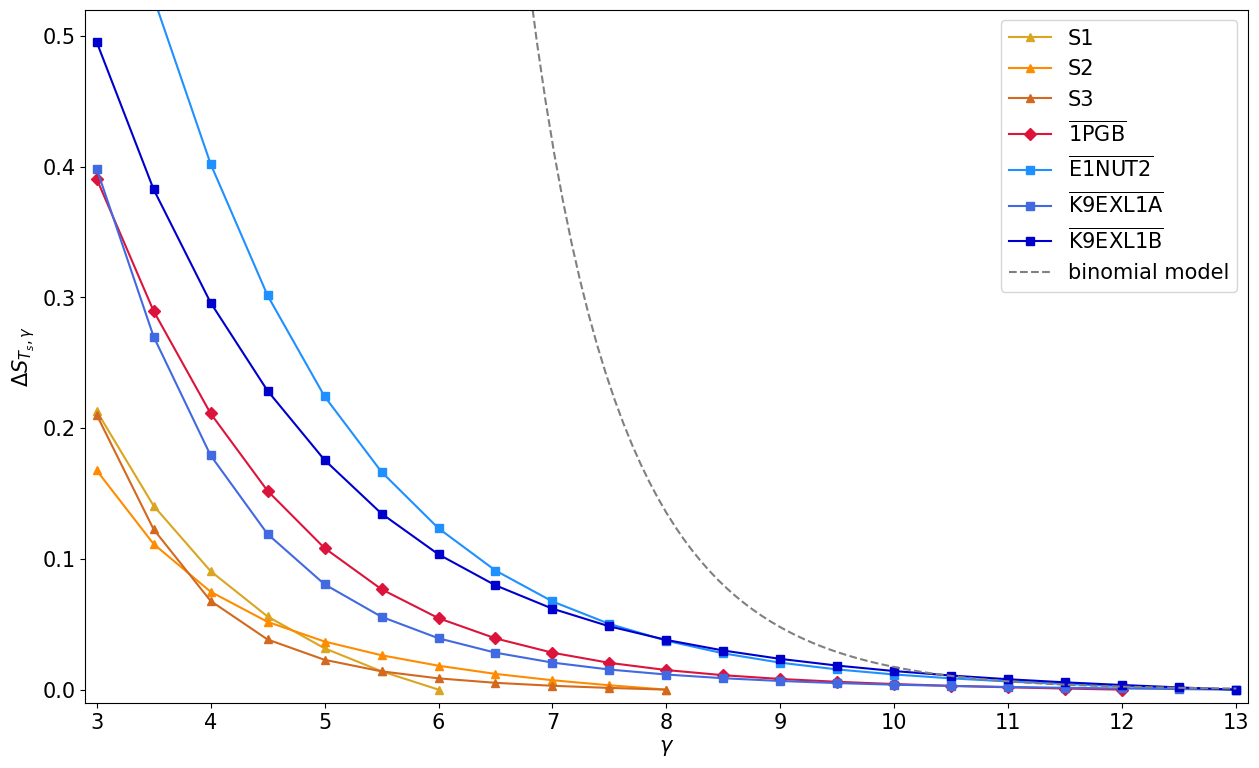

In [11]:
fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

for idx, (keys, group_tuples, group_labels) in enumerate(zip(ord_groups, ord_groups_tuples, ord_groups_labels)):
    for key, tupl, label in zip(keys, group_tuples, group_labels):
        df = Simp_dict[key]
        (color, marker) = tupl
        ax.plot(df['gamma'], df['DeltaS'], color = color, marker = marker, label = label)
    
gamma = np.linspace(5.5, 13., 100)
bin_pred = np.array([binomial_local_entropy(g) for g in gamma])
bin_S, bin_mean_d = bin_pred[:, 0], bin_pred[:, 1]
ax.plot(gamma, bin_S, color = 'grey', linestyle = '--', label = 'binomial model')

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\Delta S_{T_{s}, \gamma}$')
ax.set_ylim([-0.01, 0.52])
ax.set_xlim([2.9, 13.1])
ax.legend()
ax.set_xticks(np.arange(13 - 2) + 3)
ax.set_xticklabels(np.arange(13 - 2) + 3);

plt.savefig(f'plots/DeltaS_gamma.png', bbox_inches='tight');

---
### Local Entropy curve vs Local Entropy derivative

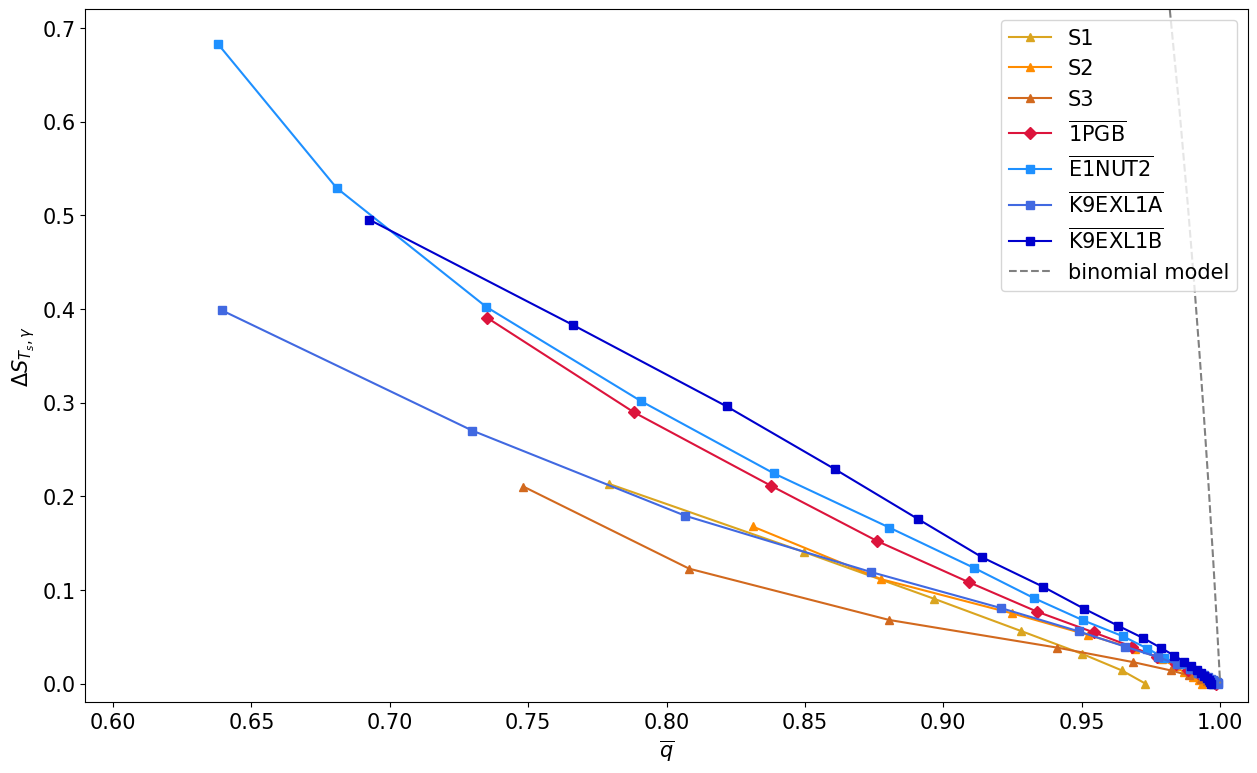

In [12]:
fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

for idx, (keys, group_tuples, group_labels) in enumerate(zip(ord_groups, ord_groups_tuples, ord_groups_labels)):
    for key, tupl, label in zip(keys, group_tuples, group_labels):
        df = Simp_dict[key]
        (color, marker) = tupl
        ax.plot(1. - abs(df['dS']), df['DeltaS'], color = color, marker = marker, label = label)
        
gamma = np.linspace(5.5, 50., 300)
bin_pred = np.array([binomial_local_entropy(g) for g in gamma])
bin_S, bin_mean_q = bin_pred[:, 0], 1. - bin_pred[:, 1]
ax.plot(bin_mean_q, bin_S, color = 'grey', linestyle = '--', label = 'binomial model')

ax.set_xlabel(r'$\overline{q}$')
ax.set_ylabel(r'$\Delta S_{T_{s}, \gamma}$')
ax.set_ylim([-0.02, 0.72])
ax.set_xlim([0.59, 1.01])
ax.legend(loc = 'upper right');

plt.savefig(f'plots/supp_mat/DeltaS_q.png', bbox_inches='tight');

---
### Local Entropy derivative

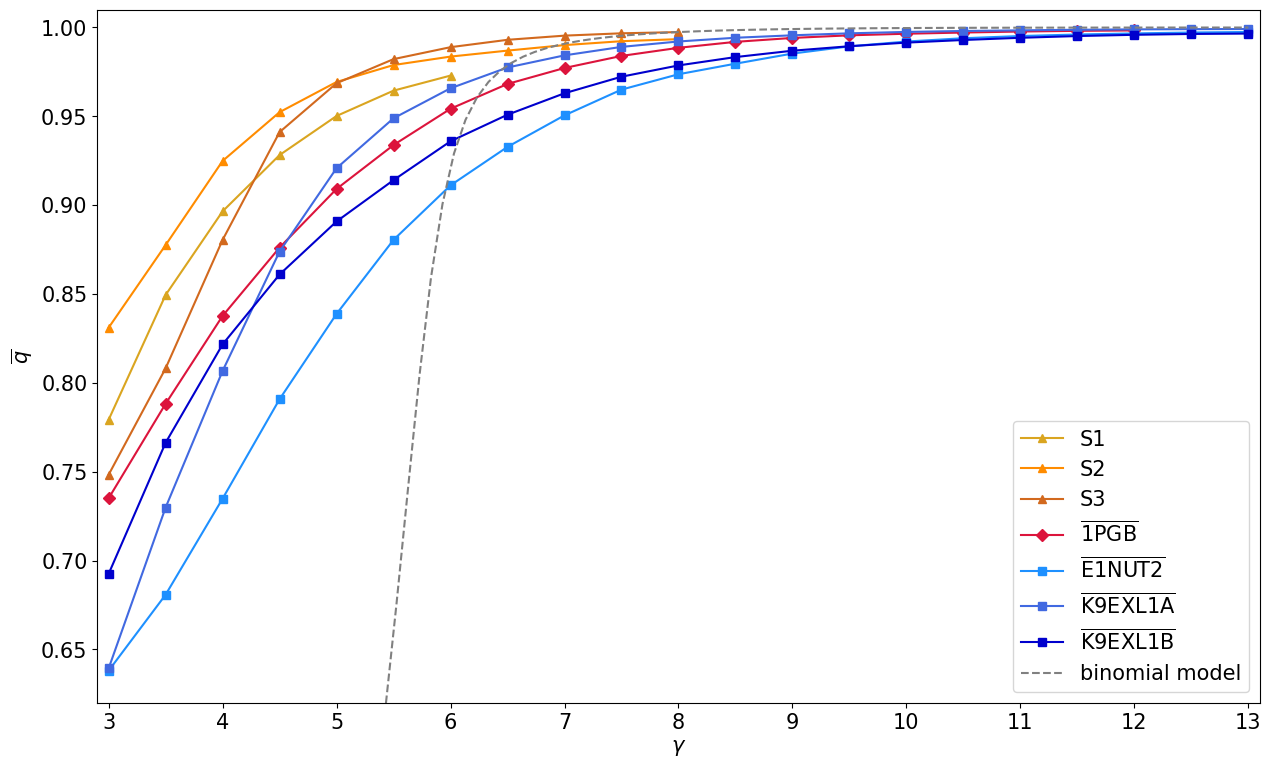

In [13]:
fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

for idx, (keys, group_tuples, group_labels) in enumerate(zip(ord_groups, ord_groups_tuples, ord_groups_labels)):
    for key, tupl, label in zip(keys, group_tuples, group_labels):
        df = Simp_dict[key]
        (color, marker) = tupl
        ax.plot(df['gamma'], 1. - abs(df['dS']), color = color, marker = marker, label = label)
    
gamma = np.linspace(3., 13., 100)
bin_pred = np.array([binomial_local_entropy(g) for g in gamma])
bin_S, bin_mean_d = bin_pred[:, 0], bin_pred[:, 1]
ax.plot(gamma, 1. - bin_mean_d, color = 'grey', linestyle = '--', label = 'binomial model')

ax.set_ylim([0.62, 1.01])
ax.set_xlim([2.9, 13.1])
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\overline{q}$')
ax.legend()
ax.set_xticks(np.arange(13 - 2) + 3)
ax.set_xticklabels(np.arange(13 - 2) + 3);

plt.savefig(f'plots/supp_mat/q_gamma.png', bbox_inches='tight');

---
### Bad

In [14]:
ord_groups = [
    ['1PGB-wt_s0', '1PGB-MOD1_s0'],
    ['1PGB-PFAM1_s0', '1PGB-PFAM1-MOD_s0'],
    ['1PGB-PFAM2_s0', '1PGB-PFAM2-MOD_s0'],
    ['1PGB-PFAM3_s0', '1PGB-PFAM3-MOD_s0'],
]

In [15]:
ord_groups_tuples = [
    [('forestgreen', 'o'), ('forestgreen', 'D')],
    [('royalblue', 'o'), ('royalblue', 'D')],
    [('crimson', 'o'), ('crimson', 'D')],
    [('goldenrod', 'o'), ('goldenrod', 'D')],
]

In [16]:
for i in np.arange(3) + 1:
    with open(f'RestrainedMetropolis/results/MM_1PGB-PFAM{i}_T0.0032/README.txt', 'r') as f:
        lines = f.readlines()
    label = lines[2].split(' ')[-1][:-1]
    seq = lines[6].split(' ')[-1][:-1]
    print(f'PFAM{i}\t{label}\t{seq}')

PFAM1	E1NUT2	TVYHFQYDKKGTSIRQDFAAVNKEIAEMHFKEYATESGLDAHFAYNEANQTFVYKD
PFAM2	K9EXL1A	EVYTFYYRTQNQNGATTVKASSPREALEYFQNFLSERGLDFNWHYESEDRVFTASE
PFAM3	K9EXL1B	AVYTFVYNTKGKNGATTVKASSPEEALEYFQNWAKENDLELDWSYDEDTKTFTGRE


In [17]:
ord_groups_labels = [
    ['1PGB', r'$\overline{\mathrm{1PGB}}$'],
    ['E1NUT2', r'$\overline{\mathrm{E1NUT2}}$'],
    ['K9EXL1A', r'$\overline{\mathrm{K9EXL1A}}$'],
    ['K9EXL1B', r'$\overline{\mathrm{K9EXL1B}}$'],
]

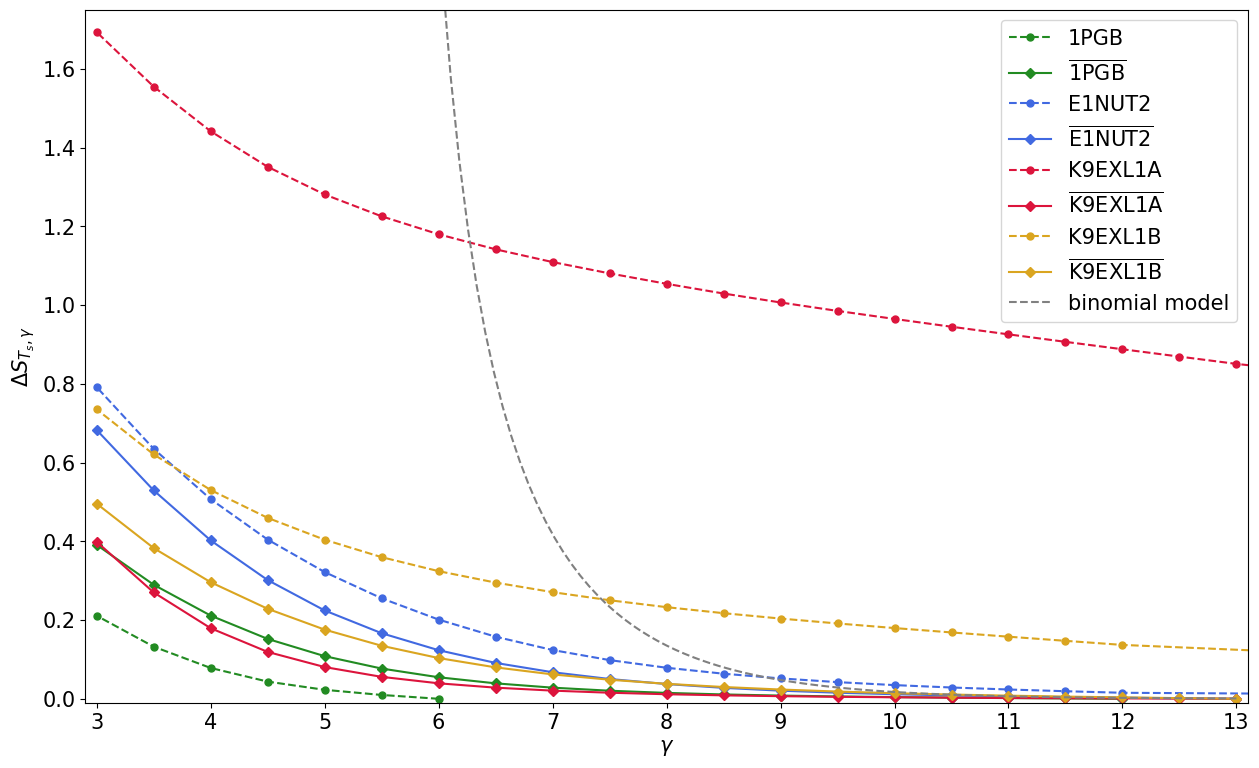

In [18]:
fig = plt.figure(figsize = (15, 9))
ax = plt.subplot(1, 1, 1)

for idx, (keys, group_tuples, group_labels) in enumerate(zip(ord_groups, ord_groups_tuples, ord_groups_labels)):
    for i, (key, tupl, label) in enumerate(zip(keys, group_tuples, group_labels)):
        df = Simp_dict[key]
        (color, marker) = tupl
        if i == 0: ls = '--'
        else: ls = '-'
        ax.plot(df['gamma'], df['DeltaS'], color = color, marker = marker, markersize = 5, ls = ls, label = label)
    
gamma = np.linspace(5.5, 13., 100)
bin_pred = np.array([binomial_local_entropy(g) for g in gamma])
bin_S, bin_mean_d = bin_pred[:, 0], bin_pred[:, 1]
ax.plot(gamma, bin_S, color = 'grey', linestyle = '--', label = 'binomial model')

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\Delta S_{T_{s}, \gamma}$')
ax.set_ylim([-0.01, 1.75])
ax.set_xlim([2.9, 13.1])
ax.legend()
ax.set_xticks(np.arange(13 - 2) + 3)
ax.set_xticklabels(np.arange(13 - 2) + 3);

plt.savefig(f'plots/supp_mat/bad_DeltaS_gamma.png', bbox_inches='tight');